# Phish no more: phishing email detection

## By Salma Houmane (Matrikel-Nr: 822192)

###### This file contains the code for replicating the analysis in the term paper.  I ran the latest version of the analysis on a macOS 14.5 operating system with an English dictionary to account for vowel mutations and special characters. The replication files comprise several Jupyter Notebooks. The scripts run under Python-version 3.11.7 but a few more additional packages may have to be installed. 

###### We organized the replication folder as follows. To replicate the analysis, paste the python code and data into one folder. Open the main script and enter your working directory. Make sure that your operating system accounts for vowel mutations, special characters, and that the additional packages were installed. Note, the computation of the machine learning model may take up to 2 hours. Comments guide you through the code.

In [123]:
InstallPackages = True #Change it to false before submitting
if InstallPackages:
    import sys
    !{sys.executable} -m pip install pandas
    !{sys.executable} -m pip install nltk
    !{sys.executable} -m pip install spacy
    !{sys.executable} -m pip install numpy
    !{sys.executable} -m pip install gensim
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install seaborn
    !{sys.executable} -m pip install pyspellchecker
    !{sys.executable} -m pip install scikit-learn
    !{sys.executable} -m pip install wordninja
    !{sys.executable} -m pip install inflect
    !{sys.executable} -m pip install wordcloud
    !{sys.executable} -m pip install autocorrect
    !{sys.executable} -m pip install xgboost
    !{sys.executable} -m!pip install beautifulsoup4 
    !{sys.executable} -m!pip install contractions
    !{sys.executable} -m!pip install Unidecode
    !{sys.executable} -m!pip install textblob
    !{sys.executable} -m!pip install eng-spacysentiment
    !{sys.executable} -m!pip install scikit-plot
    !{sys.executable} -m!pip install spacy spacytextblob

python(56408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56423) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56461) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56473) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56483) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56485) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


python(56506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [328]:
import sys
import pandas as pd
import nltk
import spacy
import numpy as np
import csv
import os
import re
import collections
import seaborn as sns
import time
import wordninja
import inflect
from spellchecker import SpellChecker
from nltk import ngrams
from nltk.corpus import words, wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.cluster import KMeans
from gensim.models.fasttext import load_facebook_model
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from pprint import pprint
from sklearn.decomposition import PCA
import warnings
from datetime import time
from autocorrect import Speller

In [330]:
DownloadAdditions = True  # Changed it to false before submitting
if DownloadAdditions:
    nltk.download("stopwords")
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('words')
    nltk.download('punkt')
    spacy.cli.download("en_core_web_lg")
    
   

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
python(10138) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.9 MB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [331]:
 nlp = spacy.load("en_core_web_lg")

In [332]:
warnings.filterwarnings('ignore')

## SEED

In [334]:
seed = 42

## CORPUS CREATION

In [335]:
csv_file_path = "CEAS_08.csv"


In [336]:
df = pd.read_csv(csv_file_path)

In [337]:
df.head()

sender  \
0                        Young Esposito <Young@iworld.de>   
1                            Mok <ipline's1983@icable.ph>   
2  Daily Top 10 <Karmandeep-opengevl@universalnet.psi.br>   
3                      Michael Parker <ivqrnai@pobox.com>   
4       Gretchen Suggs <externalsep1@loanofficertool.com>   

                                         receiver  \
0                     user4@gvc.ceas-challenge.cc   
1                   user2.2@gvc.ceas-challenge.cc   
2                   user2.9@gvc.ceas-challenge.cc   
3  SpamAssassin Dev <xrh@spamassassin.apache.org>   
4                   user2.2@gvc.ceas-challenge.cc   

                              date  \
0  Tue, 05 Aug 2008 16:31:02 -0700   
1  Tue, 05 Aug 2008 18:31:03 -0500   
2  Tue, 05 Aug 2008 20:28:00 -1200   
3  Tue, 05 Aug 2008 17:31:20 -0600   
4  Tue, 05 Aug 2008 19:31:21 -0400   

                                                                                                                                                  subject  \
0                                                                                                                               Never agree to be a loser   
1                                                                                                                                  Befriend Jenna Jameson   
2                                                                                                                                    CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/trunk: lib/Mail/SpamAssassin/PerMsgStatus.pm lib/Mail/SpamAssassin/Util/RegistrarBoundaries.pm t/uri_text.t   
4                                                                                                                              SpecialPricesPharmMoreinfo   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [12]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

## Summary Statistics of the Data

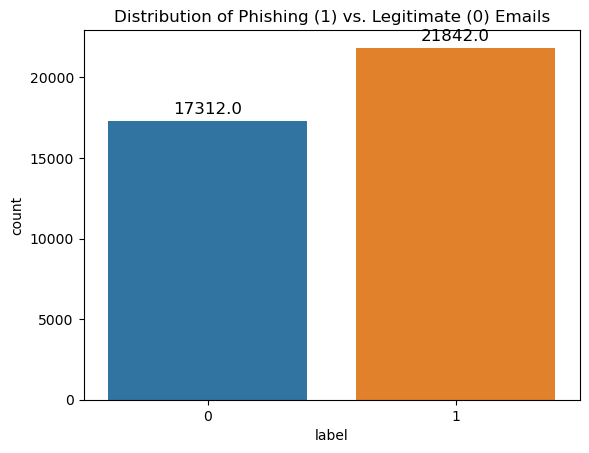

In [10]:
# Distribution of the label column
# Create the count plot
ax = sns.countplot(x='label', data=df)

# Annotate each bar with its count
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Add title to the plot
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')

# Show the plot
plt.show()

 The dataset we have, containing 21,842 spam (phishing) emails and 17,312 legitimate emails, provides a substantial amount of data for building a phishing detection machine learning model.

In [11]:
# Count the number of rows with the same subject
subject_counts = df['subject'].value_counts()

# Print the counts of each unique subject
print("Counts of each unique subject:")
print(subject_counts)

# Calculate the percentage of unique subjects
total_rows = df.shape[0]
unique_subjects = df['subject'].nunique()
unique_percentage = (unique_subjects / total_rows) * 100

print(f'\nTotal rows: {total_rows}')
print(f'Number of unique subjects: {unique_subjects}')
print(f'Percentage of unique subjects: {unique_percentage:.2f}%')
print(f'Percentage of unique subjects: {unique_percentage:.2f}%')

Counts of each unique subject:
CNN.com Daily Top 10                             2930
CNN Alerts: My Custom Alert                      1406
Re:                                               580
123                                               255
Re:                                               125
                                                 ... 
Happy Birthday wishes from Rochelle                 1
Quiet prices for must have products.                1
[PownceAPI] Re: Verify credentials                  1
[Python-3000] u'text' as an alias for 'text'?       1
[Python-Dev] PEP 370 heads up                       1
Name: subject, Length: 15436, dtype: int64

Total rows: 39154
Number of unique subjects: 15436
Percentage of unique subjects: 39.42%
Percentage of unique subjects: 39.42%


###### We see a lot of emails have the topic CNN and RE. These objects sound suspicious so in a next step, we check if CNN objects are used more in phishing emails.

In [12]:
# Filter the DataFrame where the email is phishing confirmed
df_label_1 = df[df['label'] == 1]

# Count the number of rows with the same subject
subject_counts_label_1 = df_label_1['subject'].value_counts()

# Print the counts of each unique subject for label=1
print("Counts of each unique subject where label=1:")
print(subject_counts_label_1)

# Calculate the percentage of unique subjects for label=1
total_rows_label_1 = df_label_1.shape[0]
unique_subjects_label_1 = df_label_1['subject'].nunique()
unique_percentage_label_1 = (unique_subjects_label_1 / total_rows_label_1) * 100

print(f'\nTotal number of phishing emails=1: {total_rows_label_1}')
print(f'Number of unique subjects in phishing emails: {unique_subjects_label_1}')
print(f'Percentage of unique subjects in phishing emails: {unique_percentage_label_1:.2f}%')

Counts of each unique subject where label=1:
CNN.com Daily Top 10                                                        2930
CNN Alerts: My Custom Alert                                                 1406
Re:                                                                          580
123                                                                          255
Re:                                                                          123
                                                                            ... 
Low shipping costs, you will spend less when you buy your remedy with us       1
From Concetta Rosenberg                                                        1
50 ways to meet your lover_olesia_k                                            1
TakeALookThankYouYourHealth                                                    1
Woman 38 Richter                                                               1
Name: subject, Length: 6419, dtype: int64

Total number of phish

## Our theory was true: all emails with the object CNN are indeed phishing.

## A next step is to check if there are known senders that are 'phishers'

In [13]:
# Find the top 10 senders
top_10_senders = df_label_1['sender'].value_counts().head(10)

# Print the top 10 senders
print("Top 10 senders where label=1:")
print(top_10_senders)

Top 10 senders where label=1:
<>                                                     44
Google AdWords-noreply <adwords-noreply@google.com>    36
Google AdWords <reactivation@google.com>               30
Google-AdWords-noreply <adwords-noreply@google.com>    29
Google-AdWords <reactivation@google.com>               25
Google-AdWords-Noreply <support@google.com>            23
AdWords-NoReplay <adwords-noreply@google.com>          21
Google AdWords <adwords-noreply@google.com>            16
Google-AdWords <adwords-noreply@google.com>            16
Google-AdWords <support-adwords@google.com>            12
Name: sender, dtype: int64


## We see that the sender Google Adwords as well as Adwords No Replay seem to be phishers. 

In [338]:
# Check the datatype before conversion
print(df['date'].dtype) 

object


In [339]:
# Convert 'date' column to UTC before conversion to datetime64
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')


In [340]:
# Check the datatype after conversion
print(df['date'].dtype) 

datetime64[ns, UTC]


In [341]:
# Dropping rows with NaT values in the 'date' column
df = df.dropna(subset=['date'])

# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

In [342]:
# Add a new column for the day of the week
df['DAY_OF_WEEK'] = df['date'].dt.dayofweek
# Add a new column to indicate if the email happened on a Friday
df['IS_FRIDAY'] = df['date'].dt.dayofweek == 4
# Add a new column for the hour of the email
df['HOUR'] = df['date'].dt.hour

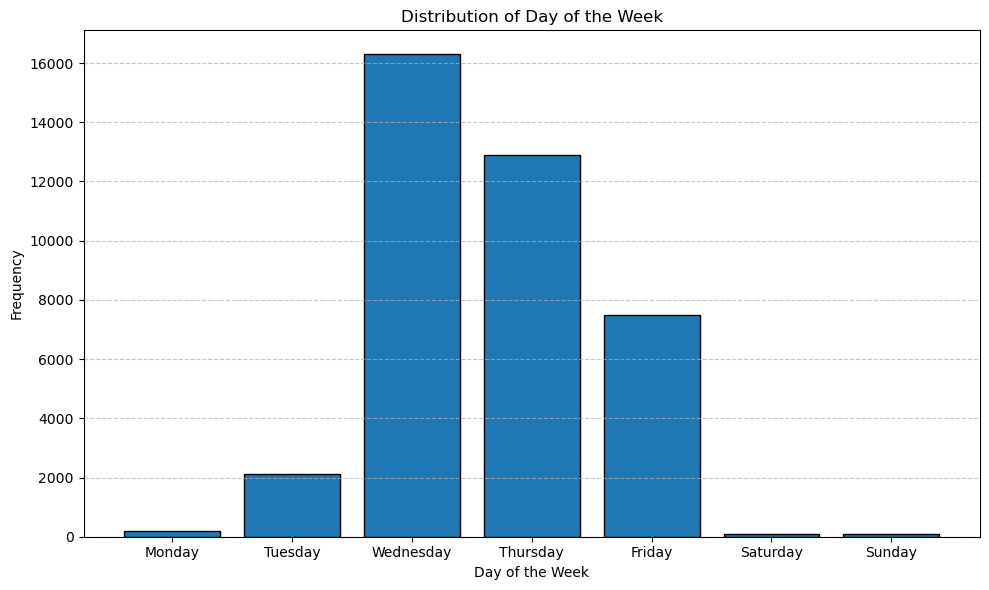

In [43]:
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['DAY_OF_WEEK'], bins=range(8), edgecolor='black', align='left', rwidth=0.8)

# Customize the plot
plt.title('Distribution of Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [45]:
# Count NaN values in 'DAY_OF_WEEK'
nan_count = df['DAY_OF_WEEK'].isna().sum()

# Total number of rows in DataFrame
total_count = df.shape[0]

# Calculate percentage of NaN values
percentage_nan = (nan_count / total_count) * 100

print(f'Number of NaN values in DAY_OF_WEEK: {nan_count}')
print(f'Total number of rows: {total_count}')
print(f'Percentage of NaN values in DAY_OF_WEEK: {percentage_nan:.2f}%')

Number of NaN values in DAY_OF_WEEK: 0
Total number of rows: 39139
Percentage of NaN values in DAY_OF_WEEK: 0.00%


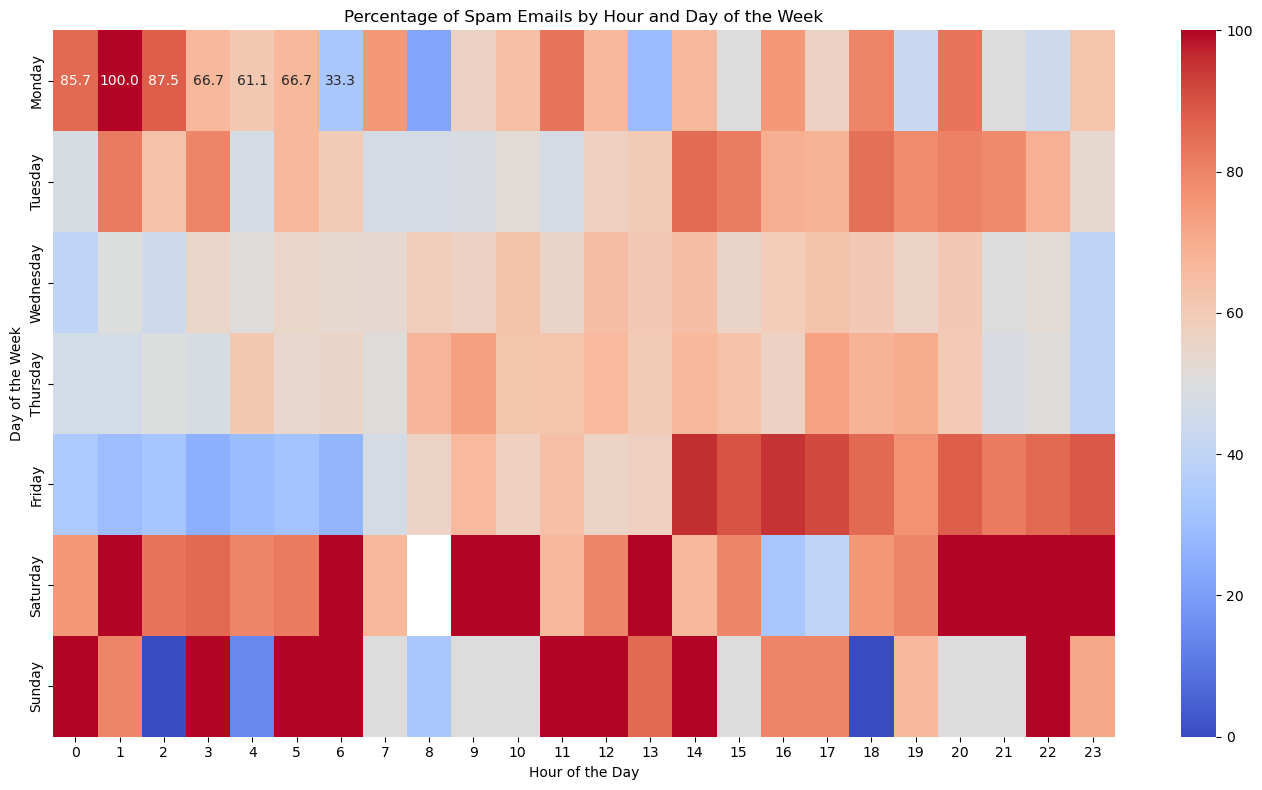

In [47]:
# Convert 'DAY_OF_WEEK' from integer to day names
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_NAME'] = df['DAY_OF_WEEK'].map(lambda x: day_names[x])

# Ensure 'DAY_NAME' is a categorical type with proper ordering
df['DAY_NAME'] = df['DAY_NAME'].astype(pd.CategoricalDtype(categories=day_names, ordered=True))

# Group by 'HOUR' and 'DAY_NAME' and calculate the percentage of phishing emails
spam_counts = df.groupby(['HOUR', 'DAY_NAME'])['label'].sum()
total_counts = df.groupby(['HOUR', 'DAY_NAME']).size()
percentage_spam = (spam_counts / total_counts) * 100

# Create a DataFrame for plotting
heatmap_data = pd.DataFrame({
    'HOUR': percentage_spam.index.get_level_values('HOUR'),
    'DAY_NAME': percentage_spam.index.get_level_values('DAY_NAME'),
    'Percentage_Spam': percentage_spam.values
})

# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot_table(index='DAY_NAME', columns='HOUR', values='Percentage_Spam')

# Ensure correct ordering of columns and index
heatmap_pivot = heatmap_pivot.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        day_names,
        categories=day_names,
        ordered=True
    )
)

# Plotting
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of Spam Emails by Hour and Day of the Week')

# Show the plot
plt.tight_layout()
plt.show()

We see a trend that most spam emails are sent over the weekend and Friday afternoon and Monday very early. We can create a binomial variable called weekend that checks if the spam email was sent between Friday after 14 until Monday 5.

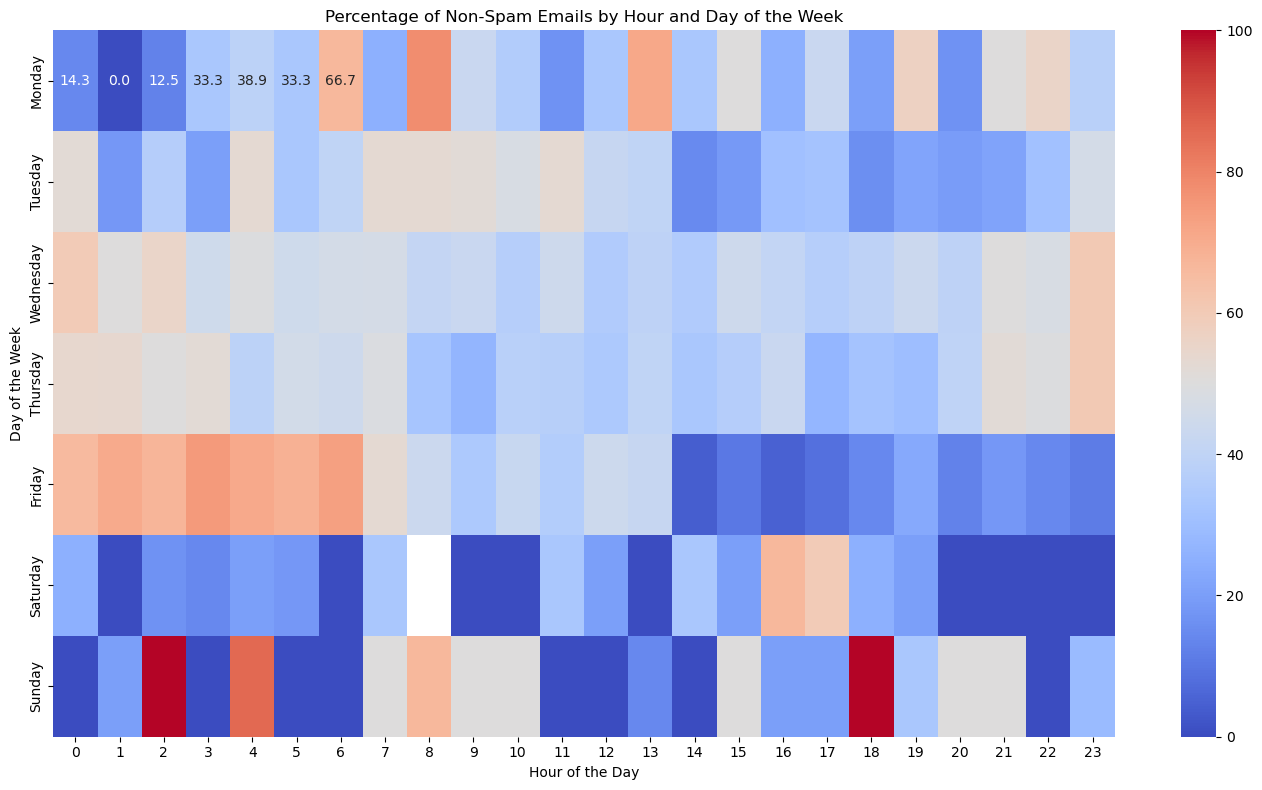

In [50]:
# Ensure 'DAY_NAME' is a categorical type with proper ordering
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_NAME'] = df['DAY_NAME'].astype(pd.CategoricalDtype(categories=day_names, ordered=True))

# Filter for non-spam emails (label == 0)
df_non_spam = df[df['label'] == 0]

# Group by 'HOUR' and 'DAY_NAME' and calculate the percentage of non-spam emails
non_spam_counts = df_non_spam.groupby(['HOUR', 'DAY_NAME']).size()
total_counts = df.groupby(['HOUR', 'DAY_NAME']).size()
percentage_non_spam = (non_spam_counts / total_counts) * 100

# Create a DataFrame for plotting
heatmap_data = pd.DataFrame({
    'HOUR': percentage_non_spam.index.get_level_values('HOUR'),
    'DAY_NAME': percentage_non_spam.index.get_level_values('DAY_NAME'),
    'Percentage_Non_Spam': percentage_non_spam.values
})

# Pivot the data for heatmap
heatmap_pivot = heatmap_data.pivot_table(index='DAY_NAME', columns='HOUR', values='Percentage_Non_Spam')

# Ensure correct ordering of columns and index
heatmap_pivot = heatmap_pivot.reindex(
    columns=range(24),  # Assuming hours from 0 to 23
    index=pd.CategoricalIndex(
        day_names,
        categories=day_names,
        ordered=True
    )
)

# Plotting
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap='coolwarm', cbar=True, vmin=0, vmax=100)

# Customize the plot
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.title('Percentage of Non-Spam Emails by Hour and Day of the Week')

# Show the plot
plt.tight_layout()
plt.show()


This trend is spam emails is relevant because it does not exist in Non-Spam emails.

# Pre-Processing

In [60]:
df.head()

sender   
0                Young Esposito <Young@iworld.de>  \
21             Zefram <veyjhby-fbuaeanj@perl.org>   
23  Mark Hammond <nkpmuffq@users.sourceforge.net>   
46                                        Nhan <>   
68        Ruby Holder <mhunseen@boxingvic.org.au>   

                                 receiver                      date   
0             user4@gvc.ceas-challenge.cc 2008-08-05 16:31:02-07:00  \
21  ozip-dhyivplsb@netlabs.develooper.com 2008-08-05 07:27:57-07:00   
23          pnperxdpv-sarswdlp@python.org 2008-08-05 16:31:17-07:00   
46          user8.2@gvc.ceas-challenge.cc 2008-08-05 16:33:26-07:00   
68            user5@gvc.ceas-challenge.cc 2008-08-06 19:34:13-07:00   

                                              subject   
0                           Never agree to be a loser  \
21  [perl #46011] overload "0+" doesn't handle int...   
23  [Spambayes-checkins] spambayes/spambayes stora...   
46                    Answers to erectile dysfunction   
68                             We offer you happiness   

                                                 body  label  urls   
0   Buck up, your troubles caused by small dimensi...      1     1  \
21  # New Ticket Created by  Zefram \n# Please inc...      0     0   
23  Update of /cvsroot/spambayes/spambayes/spambay...      0     1   
46  \n\n\n\n\n\nSee a schlub like me get lucky in ...      1     1   
68  \n\n\nWe are one of the first Internet chemist...      1     0   

          Date      Time  
0   2008-08-05  16:31:02  
21  2008-08-05  07:27:57  
23  2008-08-05  16:31:17  
46  2008-08-05  16:33:26  
68  2008-08-06  19:34:13

###### The columns were added successfully. We now have a date and time columns.

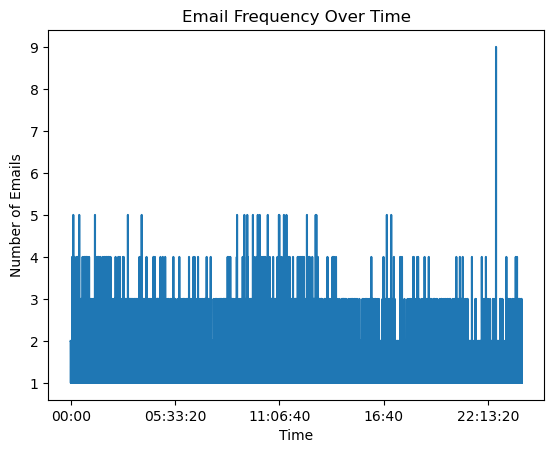

In [17]:
# Plotting the distribution of emails over time
df['Time'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Emails')
plt.show()

###### We see that emails are sent at various times but there is an increased number of emails at 22:13.

In [19]:
# Filter the DataFrame where label is 1
df_phishing = df[df['label'] == 1]

In [19]:
# Find the time with the highest number of phishing emails
time_counts = df_phishing['Time'].value_counts().sort_index()
peak_time = time_counts.idxmax()
peak_count = time_counts.max()
    
print(f"The peak time with {peak_count} emails sent is {peak_time}.")

The peak time with 9 emails sent is 22:38:18.


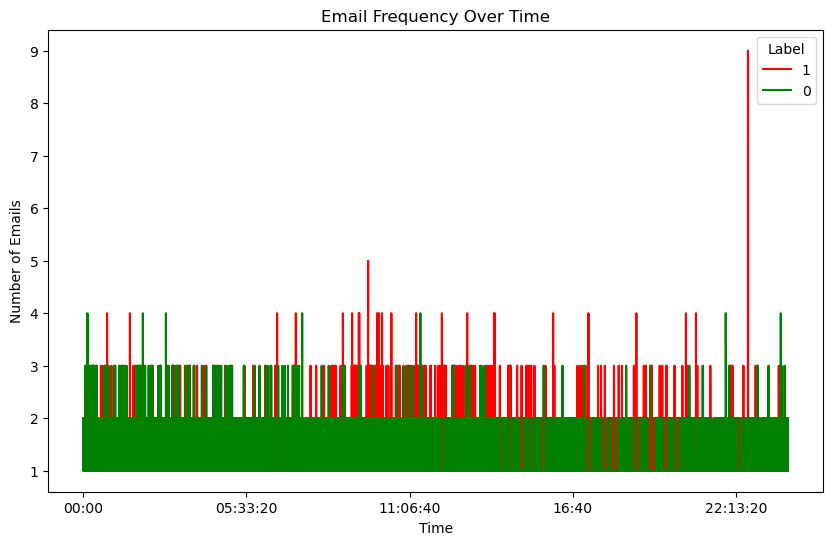

In [20]:
# Assuming 'label' is the column used for coloring
labels = df['label'].unique()

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each label with a different color
colors = ['red', 'green']  # Adjust colors as needed
for i, label in enumerate(labels):
    subset = df[df['label'] == label]
    subset['Time'].value_counts().sort_index().plot(
        kind='line', color=colors[i], label=label)

# Add title and labels
plt.title('Email Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Emails')
plt.legend(title='Label')  # Add legend to distinguish labels

# Show the plot
plt.show()

## Create sub-set of corpus

In [357]:
# Define the start and end times for the filter
start_time = time(22, 10)
end_time = time(22, 15)

# Filter the DataFrame for times at night
#df_filtered_night = df[df['Time'].apply(lambda x: start_time <= x <= end_time)]

# Create a randomized sample of 20% of the data
df_filtered_night = df.sample(frac=0.2, random_state=42)


In [267]:
print(df_filtered_night)

                                                                  sender  \
18151                       Tony Gibson <TonyfoughtSullivan@edheads.org>   
14481                                Thelma Paulson <a-alejandro@cs.com>   
9651                      Willard May <DavechampaignLowe@lifehacker.com>   
24390                              Louis Atallah <normmlwa@doc.ic.ac.uk>   
25360                                       zpyh-tjxhamifb@engr.orst.edu   
...                                                                  ...   
10320                         Facundo Batista <zopkrbwbxubyox@gmail.com>   
6892                               Christopher Adams <zfonuvo@gmail.com>   
32960  Centro de soporte - PortalProgramas <drmygdn@portalprogramas.com>   
31445                                  Michael Thomas <ysgt@bedarra.com>   
16810                                                       Gerondale <>   

                                                                                       

In [359]:
df_filtered_night.reset_index(drop=True, inplace=True)

## Lemmatization 

In [361]:
import bs4  # for BeautifulSoup (from beautifulsoup4 package)
import contractions
import unidecode
from textblob import TextBlob
from unidecode import unidecode
from bs4 import BeautifulSoup
from textblob import TextBlob

In [363]:
# Concatenate 'subject' and 'body' into a new column 'document'
df_filtered_night['document'] = df_filtered_night['subject'] + ' ' + df_filtered_night['body']


In [365]:
# Ensure the 'document' column is of type string
df_filtered_night['document'] = df_filtered_night['document'].astype(str)


##### Similarly to the authors of the main paper, we now choose to use the TF-IDF on Combined Text Data. This approach will create a TF-IDF matrix based on the combined text from both columns, preserving the relationship between 'body' and 'subject' in the vectorization process.

In [367]:
from wordcloud import WordCloud

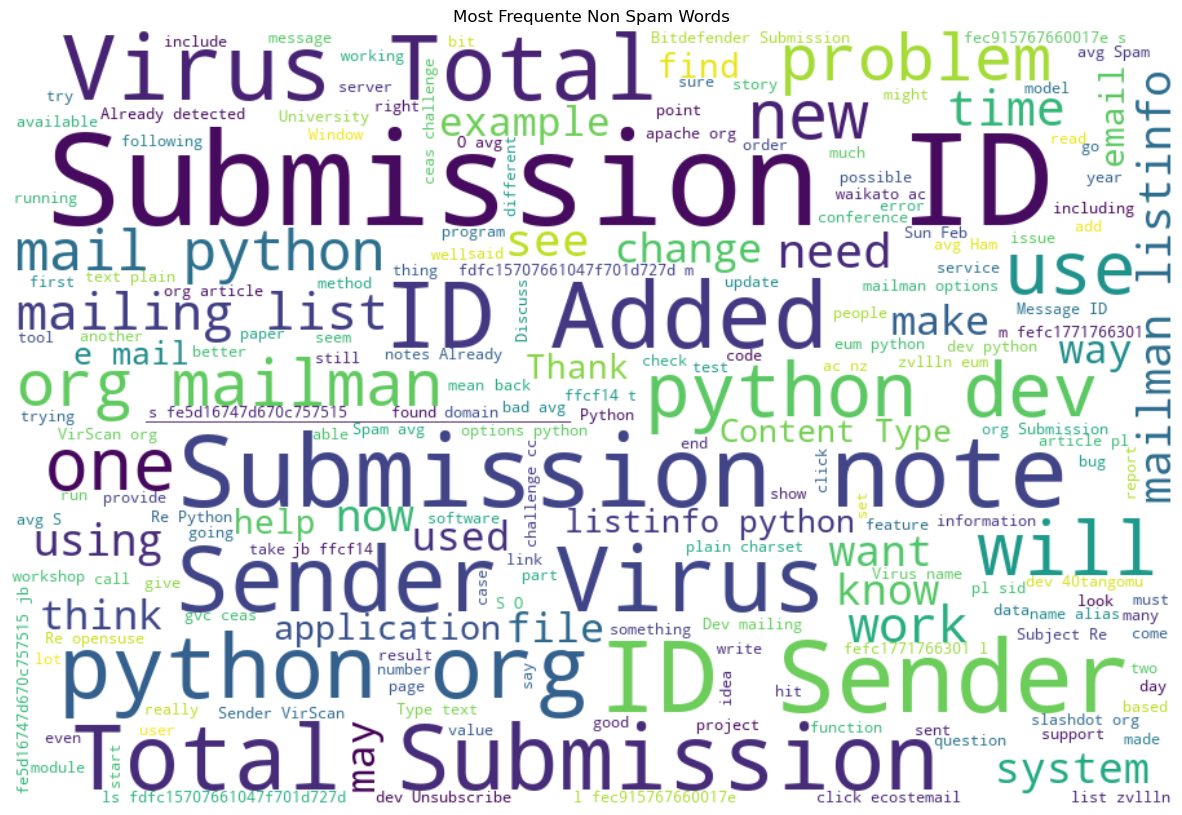

In [307]:
# Plotting word cloud form non spam messages 
ham = " ".join(df_filtered_night[df_filtered_night['label'] == 0]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Non Spam Words")
plt.show()

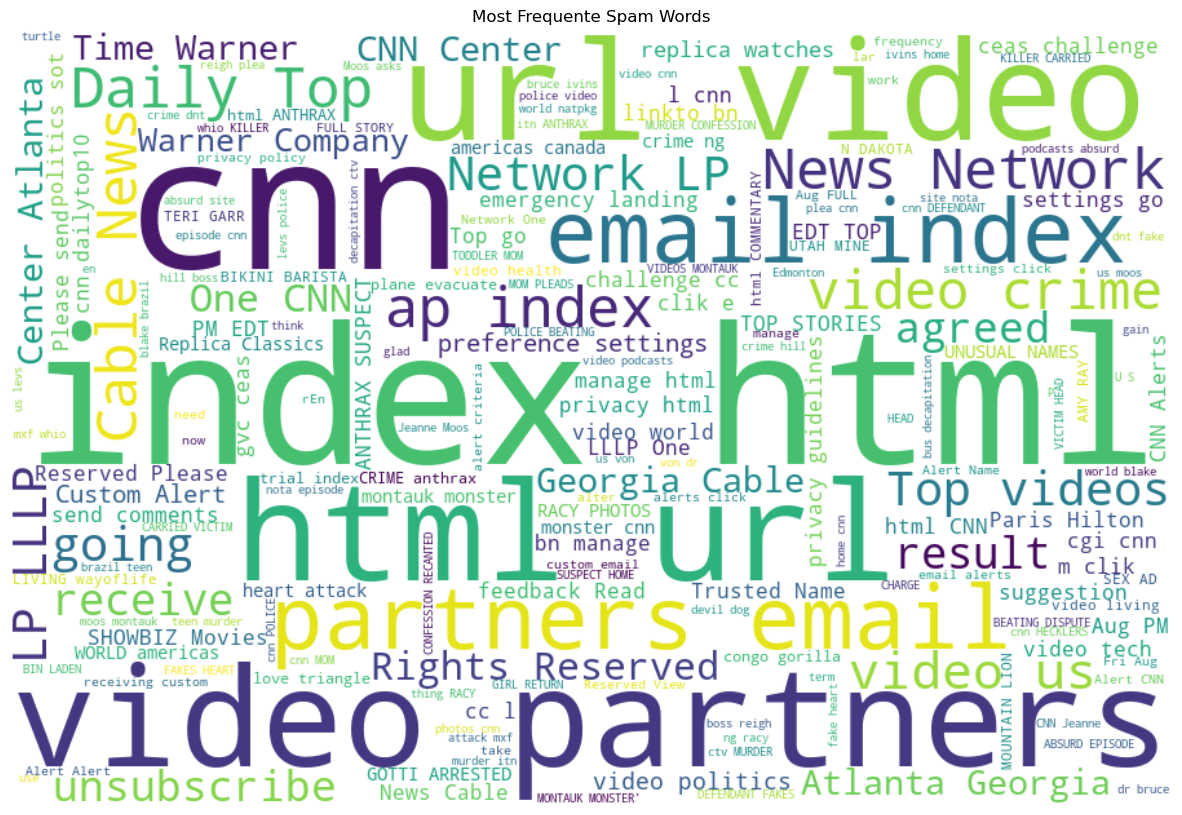

In [308]:
# Plotting word cloud form spam messages 
spam = " ".join(df_filtered_night[df_filtered_night['label'] == 1]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Spam Words")
plt.show()


In [369]:
def expand_contractions(text):
    """
    Function to expand contractions in English text.

    Contractions are shortened versions of words or syllables, often with an apostrophe, 
    such as "don't" for "do not" or "it's" for "it is". This function expands contractions
    in a given text by replacing them with their full forms.

    Parameters:
    text (str): Input text containing contractions.

    Returns:
    str: Text with expanded contractions.
    """
    return " ".join([contractions.fix(word) for word in text.split()])

In [371]:
def clean_text(text):
    """
    Function to clean text data by performing the following steps:
    - Replace newline characters with spaces
    - Remove the string 're'
    
    Parameters:
    text: Input text to be cleaned, can be of any type.
    
    Returns:
    str: Cleaned text.
    """
    # Convert the input to string, regardless of its original type
    text = str(text)
    
    cleaned_text = text.replace('\n', ' ').strip()
    cleaned_text = cleaned_text.replace('re', ' ').strip()
    return cleaned_text

In [373]:
def remove_punctuation(text):
    """
    Function to remove all punctuation marks from a string.
    
    Parameters:
    text (str): Input string from which punctuation will be removed.
    
    Returns:
    str: String without any punctuation marks.
    """
    # Define regex pattern for punctuation marks
    punctuation_pattern = r'[^\w\s]'
    
    # Replace punctuation marks with an empty string
    text = re.sub(punctuation_pattern, '', text)
    
    return text

In [375]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [377]:
# Initialize NLTK's stopwords
sw_nltk = stopwords.words('english')

# Define custom stopwords
custom_stopwords = set([
    'com', 'http', 'mail','url', 'link', 'web', 'site', 'page', 'domain', 'webpage', 'server','html','com','www','the','lm', 'amp', 'pi', 'ma', 'li', 'er', 'si', 'de', 'mod', 'fa', 'db', 'gnu', 'bin', 'lf', 'ti'
])

# Combine NLTK's stopwords with custom stopwords
stop_words = set(sw_nltk).union(custom_stopwords)

In [379]:
import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# Define your tag dictionary mapping NLTK POS tags to WordNet POS tags
tag_dict = {
    'N': wordnet.NOUN,
    'V': wordnet.VERB,
    'R': wordnet.ADV,
    'J': wordnet.ADJ
}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salmahoumane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [381]:
# Function to perform lemmatization on a given sentence
def lemmatize_sentence(sentence):
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)
    
    # Perform POS tagging on the words
    pos_list_of_tuples = nltk.pos_tag(words)
    
    # Initialize an empty list to store lemmatized words
    new_sentence_words = []
    
    # Iterate through each word and its corresponding POS tag
    for word_idx, (word, nltk_word_pos) in enumerate(pos_list_of_tuples):
        # Extract the first character of the NLTK POS tag
        nltk_word_pos_tag = nltk_word_pos[0].upper()
        
        # Check if the first character of the NLTK POS tag exists in tag_dict
        if nltk_word_pos_tag in tag_dict:
            # Get the corresponding WordNet POS tag
            wordnet_word_pos = tag_dict[nltk_word_pos_tag]
            # Lemmatize the word using the WordNet POS tag
            new_word = lemmatizer.lemmatize(word, wordnet_word_pos)
        else:
            # Lemmatize the word without specifying the POS tag
            new_word = lemmatizer.lemmatize(word)
        
        # Append the lemmatized word to the new sentence words list
        new_sentence_words.append(new_word)
    
    # Join the list of words into a new sentence
    new_sentence = " ".join(new_sentence_words)
    
    return new_sentence

In [383]:
def limit_repeated_letters(word):
    # This regular expression will match any sequence of more than two repeated letters
    pattern = re.compile(r'(.)\1{2,}')
    
    # Function to replace sequences of more than two repeated letters with exactly two
    def replace(match):
        char = match.group(1)  # The letter that was repeated
        return char * 2  # Replace with exactly two occurrences of that letter
    
    # Substitute all matches in the word with exactly two letters
    return pattern.sub(replace, word)

In [385]:
# Initialize the mistakes, correct_count and incorrect_count column
df_filtered_night['mistakes'] = 0
df_filtered_night['correct_count'] = 0
df_filtered_night['incorrect_count'] = 0

In [387]:
# Define the function to process and correct text
def process_and_correct(text):
    spell = Speller(lang='en')
    mistakes_count = 0   
    words = text.split()  # Split the text into words
    corrected_words = []  # To store the corrected words

    for word in words:
        # Apply the limit_repeated_letters function and then correct the word
        corrected_word = spell(limit_repeated_letters(word))
        
        # Check if the word was corrected
        if corrected_word != word:
            mistakes_count += 1
        
        # Add the corrected word to the list
        corrected_words.append(corrected_word)
    
    # Join the corrected words into a single string
    corrected_text = ' '.join(corrected_words)
    
    return corrected_text, mistakes_count

In [389]:
from spellchecker import SpellChecker

In [391]:
def remove_single_letters(sentence):
    # Split the sentence into words
    words = sentence.split()
    
    # Filter out single-letter words
    filtered_words = [word for word in words if len(word) > 1]
    
    # Join the remaining words back into a sentence
    cleaned_sentence = ' '.join(filtered_words)
    
    return cleaned_sentence

In [393]:
def check_sentence(sentence):
    # Initialize the SpellChecker object
    spell = SpellChecker()

    # First, remove single-letter words from the sentence
    sentence = remove_single_letters(sentence)
    
    # Split the sentence into words
    words = sentence.split()
    
    # Initialize counts and lists for correct and incorrect words
    correct_count = 0
    incorrect_count = 0
    corrected_words = []
    
    # Process each word
    for word in words:
        # Check if the word exists in the dictionary
        if word.lower() in spell:
            correct_count += 1
            corrected_words.append(word)
        else:
            incorrect_count += 1

    # Join the correct words into a cleaned sentence
    cleaned_sentence = ' '.join(corrected_words)
    
    return cleaned_sentence, correct_count, incorrect_count

In [395]:
def preprocess_text(text):
    """
    Function to preprocess text data by performing the following steps:
    - Clean text
    - Convert text to lowercase
    - Remove HTML tags
    - Remove non-alphanumeric characters
    - Remove digits
    - Remove extra whitespace
    - Remove stopwords
    - Remove punctuation marks
    - Replace diacritics (accented characters) with nearest characters
    - Replace dots with spaces
    - Expand contractions
    - Tokenize the text into words
    - Perform POS tagging on the words
    - Lemmatize each word based on its POS tag
    - Correct typos using TextBlob
    
    Parameters:
    text (str): Input text to be preprocessed.
    
    Returns:
    str: Preprocessed text.
    """
    # Clean text
    text = clean_text(text)
    
    # Convert text to lowercase
    text = text.lower()

    # Expand contractions
    text = expand_contractions(text)
    
    # Remove HTML tags (if any)
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Replace diacritics (accented characters) with nearest characters
    text = unidecode(text, errors="preserve")
    
    # Replace dots with spaces
    text = re.sub(r'\.', ' ', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in sw_nltk]
    
    # Remove punctuation marks
    text = remove_punctuation(' '.join(words))
    
    # Perform POS tagging on the words
    pos_list_of_tuples = nltk.pos_tag(words)
    
    # Lemmatize each word based on its POS tag
    lemmatized_words = []
    for word, nltk_word_pos in pos_list_of_tuples:
        nltk_word_pos_tag = nltk_word_pos[0].upper()
        if nltk_word_pos_tag in tag_dict:
            wordnet_word_pos = tag_dict[nltk_word_pos_tag]
            lemmatized_word = lemmatizer.lemmatize(word, wordnet_word_pos)
        else:
            lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
    
    # Join the lemmatized words back into a single string
    lemmatized_text = ' '.join(lemmatized_words)
    
    # Correct typos 
    corrected_text, mistakes_count = process_and_correct(lemmatized_text)

    #Check how many still makes sense
    cleaned_sentence, correct_count, incorrect_count = check_sentence(corrected_text)

    return cleaned_sentence, mistakes_count, correct_count, incorrect_count


In [397]:
#Usage:
df_filtered_night[['corrected_text', 'mistakes','correct_count','incorrect_count']] = df_filtered_night['document'].apply(lambda text: pd.Series(preprocess_text(text)))

# Print the preprocessed DataFrame
print(df_filtered_night.head())

                                           sender  \
0    Tony Gibson <TonyfoughtSullivan@edheads.org>   
1             Thelma Paulson <a-alejandro@cs.com>   
2  Willard May <DavechampaignLowe@lifehacker.com>   
3           Louis Atallah <normmlwa@doc.ic.ac.uk>   
4                    zpyh-tjxhamifb@engr.orst.edu   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            receiver  \
0                                                                                                                                                                

In [398]:
# Set the maximum column width to None (no limit)
pd.set_option('display.max_colwidth', None)

# Now print the column
print(df_filtered_night['corrected_text'])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        look tag her visit replica clas

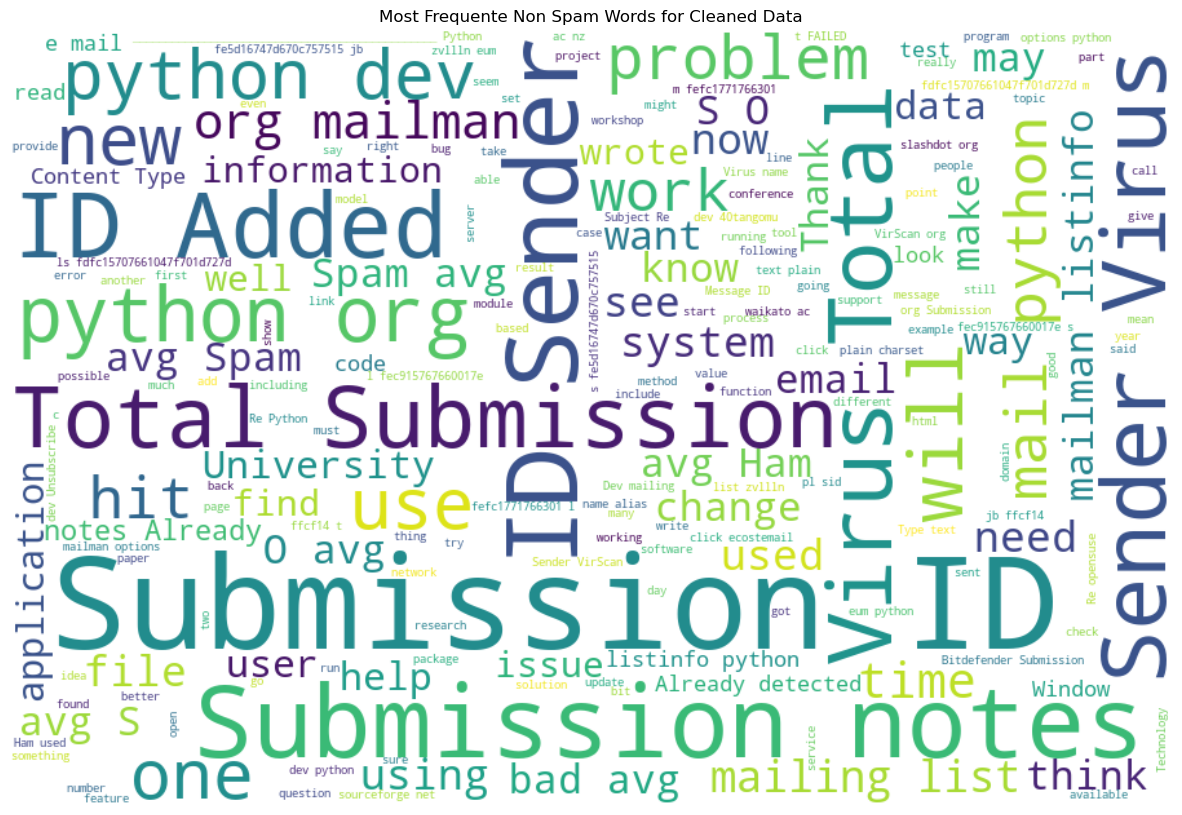

In [399]:
# Plotting word cloud form non spam messages  after cleaning
ham = " ".join(df_filtered_night[df_filtered_night['label'] == 0]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(ham)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Non Spam Words for Cleaned Data")
plt.show()

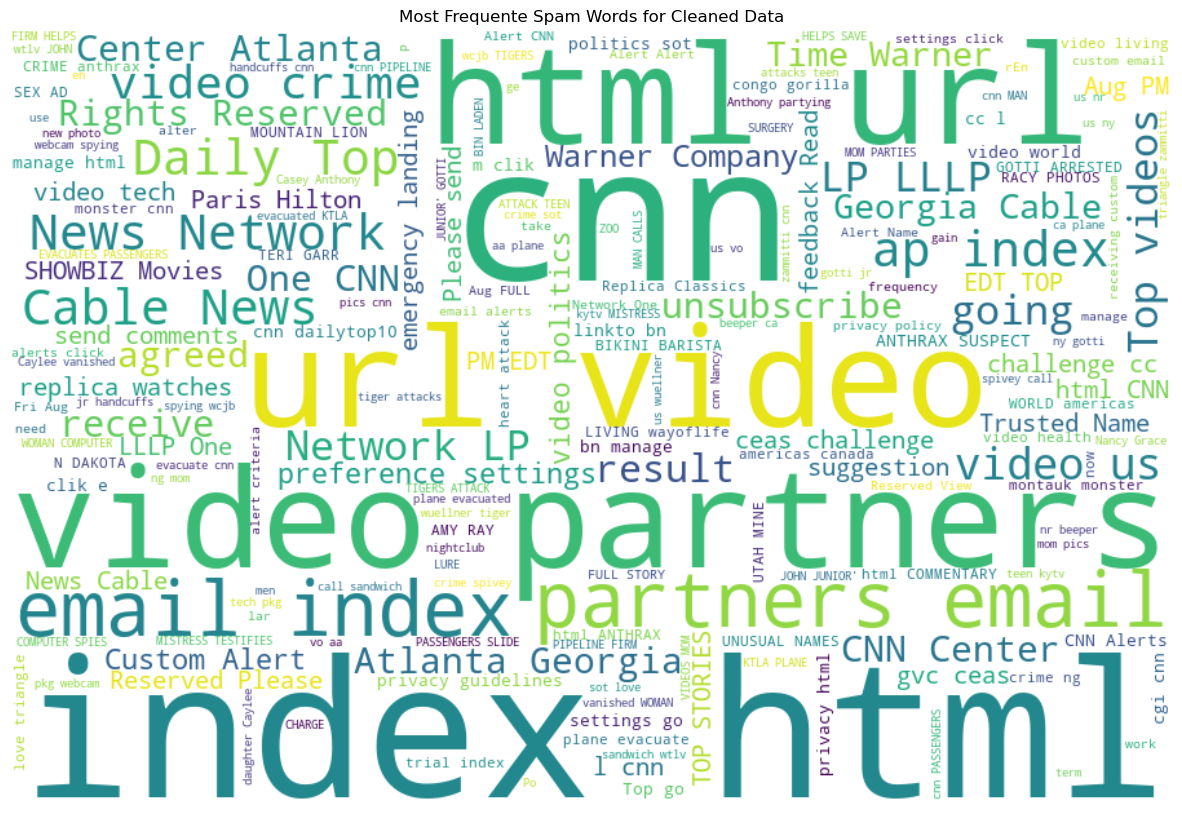

In [400]:
# Plotting word cloud form spam messages after cleaning
spam = " ".join(df_filtered_night[df_filtered_night['label'] == 1]['document'])
wordcloud = WordCloud(width = 900, height = 600, max_words = 200, background_color ='white').generate(spam)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Most Frequente Spam Words for Cleaned Data")
plt.show()

# Main code

# Method

## Latent Semantic Analysis
##### LSA helps in retrieving relevant documents based on semantic similarity rather than just keyword matching.

In [405]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [407]:
from sklearn.decomposition import TruncatedSVD

In [409]:
# Define the parameters for TfidfVectorizer
tfidf = TfidfVectorizer(
    lowercase=False,    # Do not convert words to lowercase
    stop_words=None,    # Do not remove any stop words
    ngram_range=(1, 1),  # Use unigrams (single words)
    max_df=0.99,         # Ignore terms that appear in more than 99% of documents
    min_df=0.01          # Ignore terms that appear in less than 1% of documents
)

In [411]:
# Identify NaN values of body
nan_indices = df_filtered_night['document'].isnull()

# Handle NaN values (replace with empty string)
df_filtered_night['document'].fillna('', inplace=True)

In [413]:
# Print the DataFrame head to verify changes
print(df_filtered_night.head())

                                           sender  \
0    Tony Gibson <TonyfoughtSullivan@edheads.org>   
1             Thelma Paulson <a-alejandro@cs.com>   
2  Willard May <DavechampaignLowe@lifehacker.com>   
3           Louis Atallah <normmlwa@doc.ic.ac.uk>   
4                    zpyh-tjxhamifb@engr.orst.edu   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            receiver  \
0                                                                                                                                                                

In [415]:
# Fit and transform the text data
tfidf_train_sparse = tfidf.fit_transform(df_filtered_night['document'])

In [417]:
#We now convert the TF-IDF transformed data into a a pandas DataFrame
#The columns of the DataFrame are set to the feature names learned by TfidfVectorizer, which represent the vocabulary of the text data after TF-IDF transformation.
#Each row represents a document and each column represents a term weighted by its TF-IDF value.
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), columns=tfidf.get_feature_names_out())

In [419]:
tfidf_train_df.head()

00  000  0000   01  0100   02  0200   03   04  0400  ...  yahoo  year  \
0  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...    0.0   0.0   
1  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...    0.0   0.0   
2  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...    0.0   0.0   
3  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...    0.0   0.0   
4  0.0  0.0   0.0  0.0   0.0  0.0   0.0  0.0  0.0   0.0  ...    0.0   0.0   

   years  yes  yet       you      your  yourself  zammitti  zvllln  
0    0.0  0.0  0.0  0.088320  0.000000       0.0       0.0     0.0  
1    0.0  0.0  0.0  0.165054  0.000000       0.0       0.0     0.0  
2    0.0  0.0  0.0  0.079964  0.000000       0.0       0.0     0.0  
3    0.0  0.0  0.0  0.000000  0.030317       0.0       0.0     0.0  
4    0.0  0.0  0.0  0.025842  0.000000       0.0       0.0     0.0  

[5 rows x 1993 columns]

##### We now create an lsa_obj which is used to transform the TF-IDF matrix into a lower-dimensional space (10 dimensions in this case) using Truncated SVD. This transformed representation retains the most important information about the relationship between terms and documents while reducing noise and computational complexity

In [422]:
#Creating lsa_obj
lsa_obj = TruncatedSVD(n_components=10, n_iter=10000, random_state=seed)

In [424]:
##### This is a crucial step in performing Latent Semantic Analysis (LSA) on text data.
##### The reduced-dimensional representation can improve the performance of classifiers by reducing the curse of dimensionality and focusing on the most informative features.

In [426]:
# Transform the TF-IDF matrix into the reduced space
# We compute the matrix multiplication of the TF-IDF matrix (tfidf_train_df) with the matrix of right singular vectors (V_T) extracted from TruncatedSVD (lsa_obj). 
#It transforms tfidf_train_df into a lower-dimensional representation (tfidf_lsa_data) that captures the underlying topics or concepts in the text data.
tfidf_lsa_data= lsa_obj.fit_transform(tfidf_train_df)
#The reduced representation (tfidf_lsa_data) can be used to measure similarity between documents based on their topics rather than exact word matches.

In [427]:
# Extract singular values (Sigma) and right singular vectors (V_T)
#We first retrieve the singular values (Sigma and V_T) obtained during the SVD computation. 
#Singular values indicate the importance or strength of each latent concept (or topic) represented by the components.
#Larger values indicate more significant topics or concepts in the dataset.
#In other words, topics with higher singular values explain more variance in the original TF-IDF matrix.
Sigma= lsa_obj.singular_values_
#Each row of V_T represents a topic (or latent concept) and each column represents a term from the original TF-IDF matrix. 
#The values in V_T show the importance (or weight) of each term in each topic.
V_T = lsa_obj.components_.T
#Each row (V_T[i]) represents a topic. 
#Positive values indicate positive correlation with terms, implying those terms are important in defining that topic. 
#Negative values suggest an inverse relationship.

In [428]:
lsa = pd.DataFrame(data=tfidf_lsa_data, columns=[f'Latent_concept_{r}' for r in range (0,len(tfidf_lsa_data[1]))])
#lsa DataFrame will have rows corresponding to documents and columns corresponding to latent concepts or topics identified by LSA.

In [429]:
lsa
#Each column (Latent_concept_0, Latent_concept_1, ..., up to Latent_concept_n-1) represents a latent concept. 
#The values in these columns indicate the strength or relevance of each concept in each document.
#It can also be used to visualize the distribution of topics across documents using various plotting techniques.

Latent_concept_0  Latent_concept_1  Latent_concept_2  Latent_concept_3  \
0             0.154220         -0.043934          0.026400          0.510330   
1             0.206259         -0.073395          0.007261          0.016863   
2             0.168532         -0.053976          0.009051          0.275292   
3             0.313599         -0.137875          0.009459          0.033512   
4             0.338947         -0.143743         -0.021815          0.030256   
...                ...               ...               ...               ...   
7823          0.283777         -0.113016          0.015747          0.075344   
7824          0.321743         -0.174812         -0.174956         -0.374670   
7825          0.377026         -0.204759         -0.111695         -0.176455   
7826          0.092033          0.004691         -0.000173          0.031573   
7827          0.103791         -0.008763          0.027837          0.565136   

      Latent_concept_4  Latent_concept_5  Latent_concept_6  Latent_concept_7  \
0             0.378398          0.009818         -0.066600          0.023045   
1            -0.034495         -0.012602         -0.035495          0.059445   
2             0.188412         -0.061109         -0.006818          0.006433   
3            -0.096380         -0.082378          0.017711         -0.054819   
4            -0.078366         -0.090500         -0.016957         -0.022352   
...                ...               ...               ...               ...   
7823         -0.071255          0.036307          0.073531         -0.030661   
7824          0.435820          0.116902          0.041091         -0.043499   
7825          0.147296         -0.031254         -0.056221          0.038238   
7826          0.005503          0.054291          0.102744          0.128628   
7827          0.464540         -0.068736         -0.055944          0.007511   

      Latent_concept_8  Latent_concept_9  
0             0.016199         -0.025215  
1             0.118448         -0.120985  
2             0.020668         -0.040248  
3            -0.170489          0.159966  
4            -0.147925          0.159935  
...                ...               ...  
7823          0.016914         -0.008357  
7824         -0.013720         -0.029758  
7825          0.017582         -0.051189  
7826          0.509827          0.555776  
7827         -0.028081          0.023426  

[7828 rows x 10 columns]

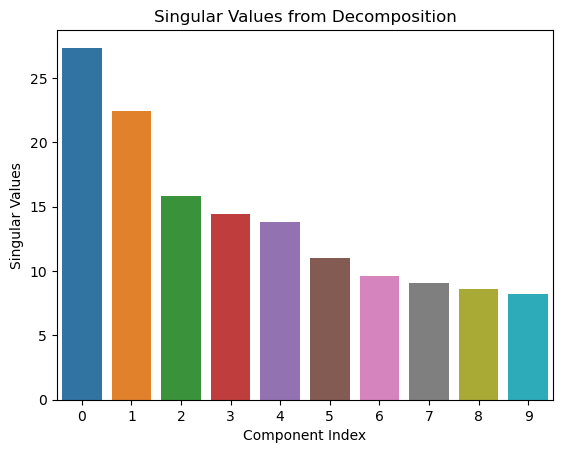

In [430]:
#Plotting to visualize the distribution or magnitude of the singular values (Sigma) derived from the decomposition process.
sns.barplot(x=list(range(len(Sigma))), y=Sigma)
plt.xlabel('Component Index')
plt.ylabel('Singular Values')
plt.title('Singular Values from Decomposition')
plt.show()

##### We see that the first singular values is much larger than the rest. This indicates that one of the components (corresponding to that singular values) is sufficient to capture most of the variability in our dataset. On the other hand, the 8 following singular values are relatively similar in magnitude and not that much lower than the first, it suggests that more components are needed to effectively represent the dataset.

In [432]:
#We now construct a Pandas DataFrame called term_concept_matrix from the given data V_T, 
#It transposes the matrix of singular vectors obtained from the matrix decomposition technique.
#It provides a structured representation of how terms (features) are associated with each latent concept (topic) derived from the matrix decomposition
term_concept_matrix = pd.DataFrame(data=V_T, 
                                 index = tfidf.get_feature_names_out(), #terms N 792
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])]) #topics 20

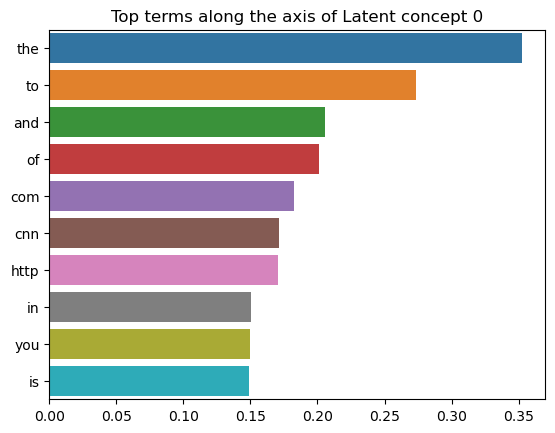

In [433]:
# Extracting the latent concept (topic) 0 from the term_concept_matrix
latent_concept = term_concept_matrix['Latent_concept_0']

# Sorting the latent concept by values in descending order to find the most significant terms
latent_concept = latent_concept.sort_values(ascending=False)

# Selecting the top 10 terms that contribute the most to latent concept 0
top_10 = latent_concept[:10]

# Plotting the top 10 terms contributing to latent concept 0 using a bar plot
plt.title('Top terms along the axis of Latent concept 0')
fig = sns.barplot(x=top_10.values, y=top_10.index)


#### The top term in Latent Concept 0 is can which can be used in different contexts but hints to possibility to do something, call to action even. The other important terms are all related to technology (video, html, www, com, http, email) as well as index which is a broad word, partner, and curl. 

In [435]:
#We now add a new column named 'token' to the DataFrame term_concept_matrix
term_concept_matrix['token'] = term_concept_matrix.index
#This new column 'token' will contain the same values as the index of term_concept_matrix

In [436]:
term_concept_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1993 entries, 00 to zvllln
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latent_concept_0  1993 non-null   float64
 1   Latent_concept_1  1993 non-null   float64
 2   Latent_concept_2  1993 non-null   float64
 3   Latent_concept_3  1993 non-null   float64
 4   Latent_concept_4  1993 non-null   float64
 5   Latent_concept_5  1993 non-null   float64
 6   Latent_concept_6  1993 non-null   float64
 7   Latent_concept_7  1993 non-null   float64
 8   Latent_concept_8  1993 non-null   float64
 9   Latent_concept_9  1993 non-null   float64
 10  token             1993 non-null   object 
dtypes: float64(10), object(1)
memory usage: 186.8+ KB


In [437]:
# Temporarily set the display options
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(term_concept_matrix)

                                                 Latent_concept_0  \
00                                                       0.010888   
000                                                      0.007695   
0000                                                     0.003844   
01                                                       0.039605   
0100                                                     0.006131   
02                                                       0.018575   
0200                                                     0.003980   
03                                                       0.009769   
04                                                       0.013486   
0400                                                     0.003813   
05                                                       0.046329   
0500                                                     0.005724   
06                                                       0.043812   
07                                

In [438]:
term_concept_matrix = term_concept_matrix.drop('token', axis=1)

### Latent Dirichlet Allocation 

We both did LSA and LSD because LSA attempts to discover the underlying relationships between words, whereas LDA seeks to discover the underlying topics in a corpus of text. And we wanted to examine both.

#### Get document topics function

In [158]:
def get_document_topics_matrix(statements, num_topics, corpus, model):
    
    """
    
    This function returns the document to topic matrix.
    
    """
    
    get_document_topics = [model.get_document_topics(item) for item in corpus]
    
    document_topics = pd.DataFrame(columns=['topic_' + str(i) for i in range(1,num_topics+1)],index=range(0,len(statements)))

    d=0
    g=0
    for r in range(0, len(statements)):
        if statements[r]!="":
            document_topics[d:(d+1)] = 0
            for t in (range(0, len(get_document_topics[g]))):
                document_topics.loc[(r):(r),str("topic_"+str((get_document_topics[g][t][0]+1)))]=get_document_topics[g][t][1]  
            g=g+1

        d=d+1
    
    return document_topics

#### Training function

In [211]:
def train_lda_model(statements, num_topics, trim):
    
    """
    
    This function trains the LDA.
    
    """
    
    docs = []
    for statement in statements:
        doc = nlp(statement)
        tokens = [t.text.lower() for t in doc]
        
        if tokens:
            docs.append(tokens)
    
    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=10, no_above=trim)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    temp = dictionary[0]
    id2word = dictionary.id2token
    
    chunksize = 1500
    passes = 100
    iterations = 1000
    eval_every = None
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state = seed
    )
    
    
    return model, corpus, id2word

#### Elbow curve function

In [183]:
def elbow_topics(statements, maxnumber_topics, trim):
    
    """
    
    This function is used to get the optimal number of topics in an LDA.
    
    """
    
    number_topics = range(1, maxnumber_topics + 1) 
    
    model_topics = [train_lda_model(statements, num_topics = i, trim = trim)[0] for i in number_topics]
    corpus_topics = [train_lda_model(statements, num_topics = i, trim = trim)[1] for i in number_topics]
    
    perplexityscores = [model_topics[i].log_perplexity(corpus_topics[i]) for i in range(len(model_topics))]
    coherencescores = [CoherenceModel(model=model_topics[i], corpus=corpus_topics[i], coherence='u_mass',topn = 10).get_coherence() for i in range(len(model_topics))]
    
    return pd.concat([pd.DataFrame({'Coherence': coherencescores})*(-1), pd.DataFrame({'Topics': range(1, maxnumber_topics + 1)})], axis=1) 
    
    print(perplexityscores)
    print(coherencescores)    
    
    plt.locator_params(axis='y', nbins=12)
    plt.locator_params(axis='x', nbins=maxnumber_topics + 1)
    
    plt.plot(number_topics, coherencescores)
    plt.xlabel('Number of Topics')
    plt.ylabel('coherencescores')
    plt.title('Coherence Score')
    plt.show()
    
    plt.plot(number_topics, perplexityscores)
    plt.xlabel('Number of Topics')
    plt.ylabel('perplexityscores')
    plt.title('Perplexity Score')
    plt.show()

    return result_df


#### Differences between topics

In [167]:
def plot_difference_matplotlib(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(8, 4))
    data = ax.imshow(mdiff, cmap='RdBu', origin='lower')
    plt.title(title)
    plt.colorbar(data)
    
    topic = topic = ["{}".format(i) for i in range(1, len(mdiff)+1)]
    ax.set_xticks(np.arange(len(topic)), labels=topic)
    ax.set_yticks(np.arange(len(topic)), labels=topic)
    
    ax.set_xlabel('Topic')
    ax.set_ylabel('Topic')
    
    plt.savefig("Figure_LDATopicDifferences"+ str(len(mdiff)) + ".pdf", bbox_inches='tight', dpi=300)


#### Posterior probability of tokens per topics

In [170]:
def tokens_per_topics(model):
    
    """
    
    This function is used to get the posterior probability of tokens per topics.
    
    """
    
    topics = model.show_topics(formatted=False)
    
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight])
    
    
    return pd.DataFrame(out, columns=['word', 'topic', 'probability'])  

#### Main

In [173]:
#define the trim parameter
trim_num = 0.95

In [185]:
coherence_score = elbow_topics(df_filtered_night['document'], maxnumber_topics = 10, trim = trim_num)

In [201]:
def compute_coherence_values(corpus, dictionary, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [203]:
start = 2  # Starting number of topics
limit = 15  # Ending number of topics
step = 1  # Step size

In [187]:
#set the number of topics
true_k = 5

In [189]:
#train model
model, corpus, id2word = train_lda_model(statements = df_filtered_night['document'], num_topics = true_k, trim = trim_num)

In [191]:
# print the keywords per topic
pprint(model.print_topics(num_words=10))

[(0, '0.658*"com" + 0.299*"http" + 0.014*"issue" + 0.014*"org" + 0.014*"mail"'),
 (1, '0.329*"org" + 0.292*"mail" + 0.210*"http" + 0.087*"issue" + 0.082*"com"'),
 (2, '0.799*"issue" + 0.051*"http" + 0.050*"com" + 0.050*"mail" + 0.050*"org"'),
 (3, '0.200*"http" + 0.200*"issue" + 0.200*"mail" + 0.200*"org" + 0.200*"com"'),
 (4, '0.872*"org" + 0.101*"com" + 0.015*"mail" + 0.005*"http" + 0.005*"issue"')]


- Topic 0: Dominated by "com" and "http," suggesting content that might include many website URLs or references.
- Topic 1: Contains "org," "mail," "http," "issue," and "com," which could indicate communications related to organizational emails or technical issues.
- Topic 2: Predominantly "issue," possibly indicating a focus on problems or troubleshooting.
- Topic 3: Even distribution among the terms "http," "issue," "mail," "org," and "com," which might indicate a generic or mixed topic without a clear focus.
- Topic 4: Primarily "org," suggesting content involving organizational domains or references.

In [193]:
tokens_per_topics_probability = tokens_per_topics(model)

In [195]:
#get document topics from model
#pd.set_option('display.max_rows', None)
document_topics = get_document_topics_matrix(statements = df_filtered_night['document'], num_topics = true_k, corpus = corpus, model = model)
pprint(document_topics)

     topic_1   topic_2   topic_3   topic_4   topic_5
0          0  0.980696         0         0         0
1   0.011964  0.974631         0         0         0
2          0  0.980696         0         0         0
3   0.208459  0.557971  0.123964  0.039367  0.070238
4   0.017445  0.963008  0.010374         0         0
5   0.055777  0.150045  0.764851  0.010533  0.018794
6          0  0.318036         0         0  0.679419
7   0.615387  0.061972  0.310744         0         0
8   0.055777  0.150044  0.764852  0.010533  0.018794
9   0.933336  0.047117  0.010374         0         0
10         0  0.984421         0         0         0
11  0.933327  0.047127  0.010374         0         0
12  0.787409  0.150095  0.033169  0.010533  0.018794
13         0  0.982757         0         0         0
14         0  0.982757         0         0         0
15         0  0.984421         0         0         0
16  0.876338  0.087588  0.019146         0  0.010848
17         0  0.993372         0         0    

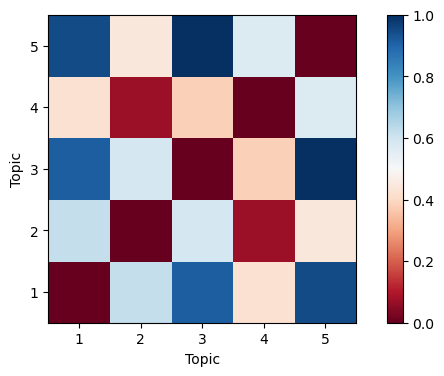

In [197]:
#plot differences between topics
mdiff, annotation = model.diff(model, distance='jensen_shannon', num_words=10)
plot_difference_matplotlib(mdiff, title="", annotation=annotation)
#We want the variables NOT to be correlated, BLUE --> the diagnal is dark red so it is perfectly correlated
#Red bad, blue good, we do not want topics to be correlated, if they are: reduce number of topics

The only suspicous detail we see here is the correlation between topic 1 and 4. 

### Sentiment Analysis

## What I have tried for sentiment analysis
- VADER (Valence Aware Dictionary and SEntiment Reasoner): Initially suggested as a rule-based approach for sentiment analysis using the vaderSentiment package. 
- SpacyTextBlob: Utilized SpacyTextBlob, a pipeline component for spaCy that allows the integration of TextBlob for sentiment analysis. This provided sentiment scores for 'positive', 'negative', and 'neutral'.
- Transformers with BERT: Explored using pre-trained models from the transformers library by Hugging Face for sentiment analysis. This involved downloading and using models like BERT for predicting sentiment.
- spaCy and Custom Sentiment Analysis: Created a custom function using the spaCy library to analyze the sentiment of text. This function returned a dictionary of sentiment scores.

## Rule Bases Approach for sentiment analysis

In [288]:
# Define urgency keywords and their scores
urgency_keywords = {
    'high': ['immediate', 'as soon as possible', 'urgent', 'emergency'],
    'medium': ['soon', 'quickly', 'important', 'pending'],
    'low': ['later', 'when possible', 'eventually']
}

def calculate_urgency_score(text):
    score = 0
    for level, keywords in urgency_keywords.items():
        for keyword in keywords:
            if keyword in text.lower():
                if level == 'high':
                    score += 3
                elif level == 'medium':
                    score += 2
                elif level == 'low':
                    score += 1
    return score

def categorize_urgency(score):
    if score >= 5:
        return 'High'
    elif score >= 3:
        return 'Medium'
    else:
        return 'Low'

# Example usage
text = "This issue is very urgent and needs to be addressed as soon as possible."
score = calculate_urgency_score(text)
category = categorize_urgency(score)
print(f"Score: {score}, Urgency Category: {category}")

Score: 8, Urgency Category: High


## Quite mediocre results

## Vader for sentiment analysis

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to calculate VADER sentiment scores
def get_vader_sentiment(text):
    sentiment_dict = analyzer.polarity_scores(text)
    return sentiment_dict


In [ ]:
# Sample data
data = {
    'document': [
        "This is a great day!",
        "I am so angry with this situation.",
        "I'm not sure how I feel about this.",
        "Absolutely terrible service!",
        "I'm so happy and excited about this event!"
    ]
}

In [ ]:
# Create a DataFrame
df_example = pd.DataFrame(data)

# Apply the sentiment analysis function to the 'document' column and store results in new columns
df_example['vader_sentiment'] = df_example['document'].apply(get_vader_sentiment)
df_example['vader_positive'] = df_example['vader_sentiment'].apply(lambda x: x['pos'])
df_example['vader_negative'] = df_example['vader_sentiment'].apply(lambda x: x['neg'])
df_example['vader_neutral'] = df_example['vader_sentiment'].apply(lambda x: x['neu'])
df_example['vader_compound'] = df_example['vader_sentiment'].apply(lambda x: x['compound'])

# Display the resulting DataFrame
print(df_example)

### Unfortunately, I saw that Vader was not great for longer texts and often put negative when it clearly was not

## Transformers with Bert for Sentiment Analysis

In [ ]:
from transformers import pipeline

# Initialize the sentiment-analysis pipeline using a pre-trained BERT model
sentiment_pipeline = pipeline('sentiment-analysis')

# Define a function to get the sentiment scores
def get_transformers_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']
    score = result['score']
    
    # Convert label to lowercase and map to respective sentiment score
    if 'NEGATIVE' in label:
        return {'transformers_sentiment': 'negative', 'transformers_score': score}
    elif 'POSITIVE' in label:
        return {'transformers_sentiment': 'positive', 'transformers_score': score}
    else:
        return {'transformers_sentiment': 'neutral', 'transformers_score': score}

# Apply the sentiment analysis function to the 'document' column and store results in new columns
df_example['transformers_sentiment'] = df_example['document'].apply(lambda x: get_transformers_sentiment(x)['transformers_sentiment'])
df_example['transformers_score'] = df_example['document'].apply(lambda x: get_transformers_sentiment(x)['transformers_score'])

# Display the resulting DataFrame
print(df_example)

### I installed 
pip install transformers
pip install pytorch 
### But still got the errror
At least one of TensorFlow 2.0 or PyTorch should be installed.
### And
The sentiment_pipeline object, created used Hugging Face's pipeline API which sometimes also lead to errors and asked for permissions


## Spacy TextBlob for sentiment analysis

In [359]:
import eng_spacysentiment

In [397]:
nlp = eng_spacysentiment.load()

In [373]:
from spacytextblob.spacytextblob import SpacyTextBlob

In [391]:
# Define a function to get the sentiment scores
def get_sentiment(text):
    doc = nlp(text)
    return doc.cats


In [395]:
# Apply the sentiment analysis function to the 'document' column
df_filtered_night['sentiment_results'] = df_filtered_night['document'].apply(lambda x: get_sentiment(x))

# Display the updated DataFrame with new sentiment score columns
print(df_filtered_night)

                                            sender   
0                qydlqcws-iacfym@issues.apache.org  \
1                qydlqcws-iacfym@issues.apache.org   
2                qydlqcws-iacfym@issues.apache.org   
3                          josh <cbthqn@gmail.com>   
4                qydlqcws-iacfym@issues.apache.org   
5             "Gregory P. Smith" <amuh@krypto.org>   
6                qydlqcws-iacfym@issues.apache.org   
7          Kenneth Lareau <mri.tplcxn@nominum.com>   
8             "Gregory P. Smith" <amuh@krypto.org>   
9                cesare76 <ratuwwkjmfgf@gmail.com>   
10                 John Barham <mgqfgos@gmail.com>   
11               cesare76 <ratuwwkjmfgf@gmail.com>   
12  "Gardos, Thomas R" <fkokwd.i.ltqtdo@intel.com>   
13            Trent Nelson <ktctpxa@onresolve.com>   
14            Trent Nelson <ktctpxa@onresolve.com>   
15            Trent Nelson <ktctpxa@onresolve.com>   
16                         charlesmano@gensler.com   
17             Guido van Ros

In [405]:
# Sentiment_results type
print(df_filtered_night['sentiment_results'].dtype)


object


In [413]:
# Convert the column to str type explicitly
df_filtered_night['sentiment_results'] = df_filtered_night['sentiment_results'].astype(str)

In [415]:
print(df_filtered_night['sentiment_results'].dtype)

object


In [417]:
def extract_sentiment_values(sentiment_str):
    # Define regex patterns for each sentiment
    positive_pattern = r"'positive':\s*(\d+\.\d+)"
    negative_pattern = r"'negative':\s*(\d+\.\d+)"
    neutral_pattern = r"'neutral':\s*(\d+\.\d+)"
    
    # Extract the values using regex search
    positive = re.search(positive_pattern, sentiment_str)
    negative = re.search(negative_pattern, sentiment_str)
    neutral = re.search(neutral_pattern, sentiment_str)
    
    # Return values as a tuple; default to 0 if not found
    return (
        float(positive.group(1)) if positive else 0.0,
        float(negative.group(1)) if negative else 0.0,
        float(neutral.group(1)) if neutral else 0.0
    )

In [419]:
# Apply the function and create new columns
df_filtered_night[['positive', 'negative', 'neutral']] = df_filtered_night['sentiment_results'].apply(extract_sentiment_values).apply(pd.Series)
print(df_filtered_night)


                                            sender   
0                qydlqcws-iacfym@issues.apache.org  \
1                qydlqcws-iacfym@issues.apache.org   
2                qydlqcws-iacfym@issues.apache.org   
3                          josh <cbthqn@gmail.com>   
4                qydlqcws-iacfym@issues.apache.org   
5             "Gregory P. Smith" <amuh@krypto.org>   
6                qydlqcws-iacfym@issues.apache.org   
7          Kenneth Lareau <mri.tplcxn@nominum.com>   
8             "Gregory P. Smith" <amuh@krypto.org>   
9                cesare76 <ratuwwkjmfgf@gmail.com>   
10                 John Barham <mgqfgos@gmail.com>   
11               cesare76 <ratuwwkjmfgf@gmail.com>   
12  "Gardos, Thomas R" <fkokwd.i.ltqtdo@intel.com>   
13            Trent Nelson <ktctpxa@onresolve.com>   
14            Trent Nelson <ktctpxa@onresolve.com>   
15            Trent Nelson <ktctpxa@onresolve.com>   
16                         charlesmano@gensler.com   
17             Guido van Ros

In [421]:
# Create the 'sentiment' column based on the comparison
df_filtered_night['sentiment'] = df_filtered_night.apply(
    lambda row: 'positive' if row['positive'] > row['negative'] else 'negative',
    axis=1
)

# Print the DataFrame to verify the result
print(df_filtered_night)

                                            sender   
0                qydlqcws-iacfym@issues.apache.org  \
1                qydlqcws-iacfym@issues.apache.org   
2                qydlqcws-iacfym@issues.apache.org   
3                          josh <cbthqn@gmail.com>   
4                qydlqcws-iacfym@issues.apache.org   
5             "Gregory P. Smith" <amuh@krypto.org>   
6                qydlqcws-iacfym@issues.apache.org   
7          Kenneth Lareau <mri.tplcxn@nominum.com>   
8             "Gregory P. Smith" <amuh@krypto.org>   
9                cesare76 <ratuwwkjmfgf@gmail.com>   
10                 John Barham <mgqfgos@gmail.com>   
11               cesare76 <ratuwwkjmfgf@gmail.com>   
12  "Gardos, Thomas R" <fkokwd.i.ltqtdo@intel.com>   
13            Trent Nelson <ktctpxa@onresolve.com>   
14            Trent Nelson <ktctpxa@onresolve.com>   
15            Trent Nelson <ktctpxa@onresolve.com>   
16                         charlesmano@gensler.com   
17             Guido van Ros

In [423]:
# Filter the DataFrame where label == 1
df_filtered_label_1 = df_filtered_night[df_filtered_night['label'] == 1]

# Calculate the percentage of each sentiment in the filtered DataFrame
sentiment_counts = df_filtered_label_1['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / len(df_filtered_label_1) * 100


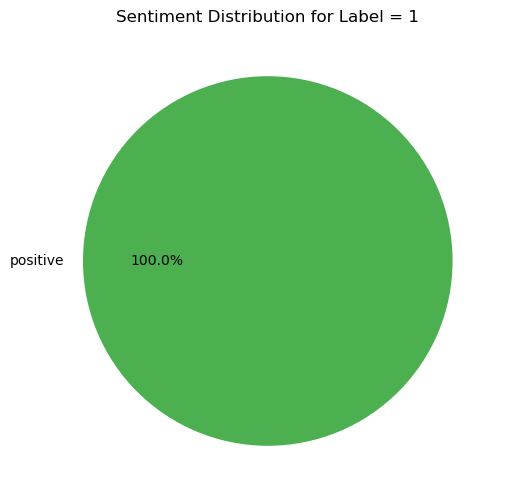

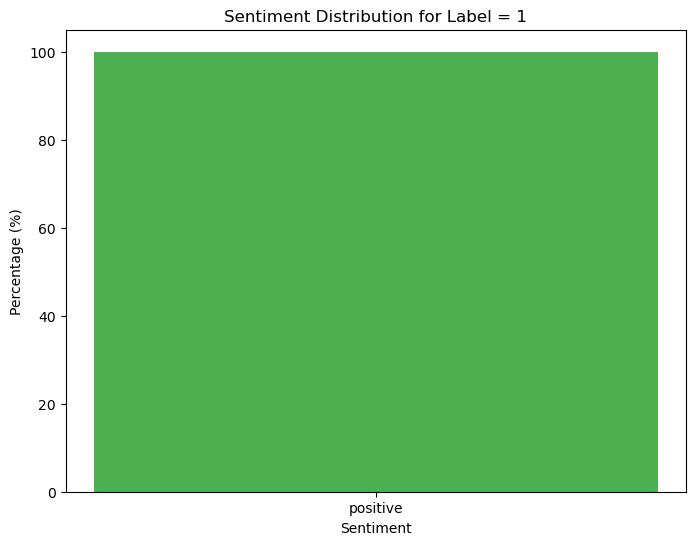

In [425]:
# Plotting the data
plt.figure(figsize=(8, 6))

# Pie chart
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', colors=['#4CAF50', '#FFC107'])
plt.title('Sentiment Distribution for Label = 1')
plt.show()

# Alternatively, you can use a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_percentages.index, sentiment_percentages, color=['#4CAF50', '#FFC107'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution for Label = 1')
plt.show()

In [427]:
# Filter the DataFrame where label == 0
df_filtered_label_0 = df_filtered_night[df_filtered_night['label'] == 0]
# Calculate the percentage of each sentiment in the filtered DataFrame
sentiment_counts = df_filtered_label_0['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / len(df_filtered_label_0) * 100


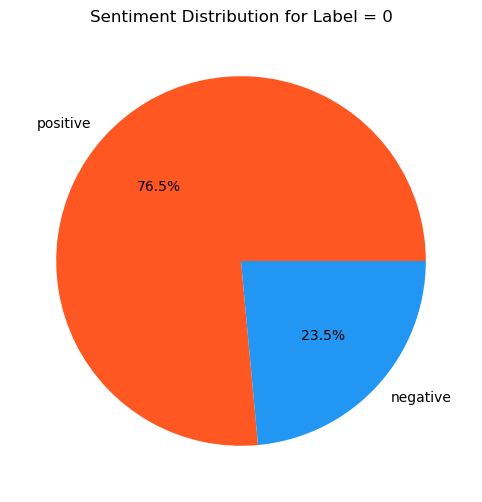

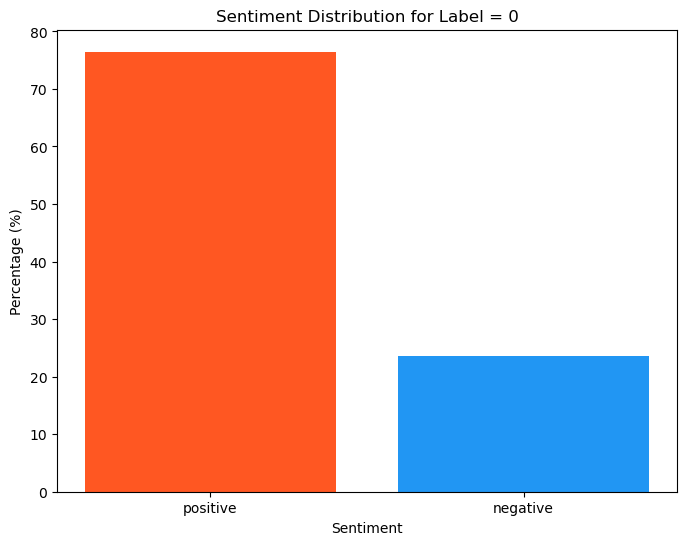

In [429]:
# Plotting the data
plt.figure(figsize=(8, 6))

# Pie chart
plt.pie(sentiment_percentages, labels=sentiment_percentages.index, autopct='%1.1f%%', colors=['#FF5722', '#2196F3'])
plt.title('Sentiment Distribution for Label = 0')
plt.show()

# Alternatively, you can use a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_percentages.index, sentiment_percentages, color=['#FF5722', '#2196F3'])
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution for Label = 0')
plt.show()


In [448]:
# Function to check if the time is late
def is_late(time):
    # Convert time to a number of hours
    hours = time.hour
    # Check if the time is between 19:00 and 07:00
    if hours >= 19 or hours < 7:
        return 1
    else:
        return 0

In [452]:
# Apply the function to create the 'Late' column
df_filtered_night['late'] = df_filtered_night['Time'].apply(is_late)

In [484]:
# Function to extract email domain
def extract_domain(sender):
    match = re.search(r'@([\w\.]+)', sender)
    return match.group(1) if match else None

# Function to extract name
def extract_name(sender):
    match = re.search(r'["<](.*?)[">]', sender)
    return match.group(1) if match else None

# Apply the functions to create new columns
df_filtered_night['domain'] = df_filtered_night['sender'].apply(extract_domain)
df_filtered_night['name'] = df_filtered_night['sender'].apply(extract_name)

# Example of creating a categorical column for named or unnamed senders
df_filtered_night['is_named'] = df_filtered_night['name'].apply(lambda x: 1 if x else 0)

print(df_filtered_night)

                                            sender   
0                qydlqcws-iacfym@issues.apache.org  \
1                qydlqcws-iacfym@issues.apache.org   
2                qydlqcws-iacfym@issues.apache.org   
3                          josh <cbthqn@gmail.com>   
4                qydlqcws-iacfym@issues.apache.org   
5             "Gregory P. Smith" <amuh@krypto.org>   
6                qydlqcws-iacfym@issues.apache.org   
7          Kenneth Lareau <mri.tplcxn@nominum.com>   
8             "Gregory P. Smith" <amuh@krypto.org>   
9                cesare76 <ratuwwkjmfgf@gmail.com>   
10                 John Barham <mgqfgos@gmail.com>   
11               cesare76 <ratuwwkjmfgf@gmail.com>   
12  "Gardos, Thomas R" <fkokwd.i.ltqtdo@intel.com>   
13            Trent Nelson <ktctpxa@onresolve.com>   
14            Trent Nelson <ktctpxa@onresolve.com>   
15            Trent Nelson <ktctpxa@onresolve.com>   
16                         charlesmano@gensler.com   
17             Guido van Ros

In [526]:
# Create the new column 'cnn'
df_filtered_night['cnn'] = df_filtered_night['subject'].apply(lambda x: 1 if 'cnn' in x.lower() else 0)

# Display the DataFrame
print(df_filtered_night)

                                            sender   
0                qydlqcws-iacfym@issues.apache.org  \
1                qydlqcws-iacfym@issues.apache.org   
2                qydlqcws-iacfym@issues.apache.org   
3                          josh <cbthqn@gmail.com>   
4                qydlqcws-iacfym@issues.apache.org   
5             "Gregory P. Smith" <amuh@krypto.org>   
6                qydlqcws-iacfym@issues.apache.org   
7          Kenneth Lareau <mri.tplcxn@nominum.com>   
8             "Gregory P. Smith" <amuh@krypto.org>   
9                cesare76 <ratuwwkjmfgf@gmail.com>   
10                 John Barham <mgqfgos@gmail.com>   
11               cesare76 <ratuwwkjmfgf@gmail.com>   
12  "Gardos, Thomas R" <fkokwd.i.ltqtdo@intel.com>   
13            Trent Nelson <ktctpxa@onresolve.com>   
14            Trent Nelson <ktctpxa@onresolve.com>   
15            Trent Nelson <ktctpxa@onresolve.com>   
16                         charlesmano@gensler.com   
17             Guido van Ros

In [557]:
# Create the 'adwords' column
df_filtered_night['adwords'] = df_filtered_night['sender'].apply(lambda x: 1 if 'adwords' in x.lower() else 0)

In [62]:
# Define a function to determine if the email was sent during the weekend period
def is_weekend(day_of_week, hour):
    if (day_of_week == 4 and hour >= 14) or (day_of_week == 5) or (day_of_week == 6) or (day_of_week == 0 and hour < 5):
        return 1
    else:
        return 0

In [64]:
# Create the 'weekend' column using the function
df_filtered_night['weekend'] = df_filtered_night.apply(lambda row: is_weekend(row['DAY_OF_WEEK'], row['HOUR']), axis=1)
# Change weekend into a binary variable
df_filtered_night['weekend_int'] = df_filtered_night['weekend'].astype(int)

In [66]:
# Print column names directly
print(df_filtered_night.columns)


Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'Date', 'Time', 'DAY_OF_WEEK', 'IS_FRIDAY', 'HOUR', 'DAY_NAME',
       'weekend'],
      dtype='object')


# Machine Learning models

In [ ]:
# Initialize an empty list to store the results
results = []

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix

In [462]:
# Convert sentiment to 0 or 1 variable
df_filtered_night['sentpositive'] = df_filtered_night['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [68]:
# Define features and target
X = df_filtered_night[['late','sentpositive','urls','is_named','cnn', 'adwords', 'weekend_int']]
y = df_filtered_night['label']

KeyError: "['late', 'sentpositive', 'is_named', 'cnn', 'adwords'] not in index"

In [488]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Linear Discriminant Analysis (LDA)

In [504]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_iris

In [490]:
# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Fit LDA model
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [492]:
# Transform the data
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

# Predict on the test set
y_pred = lda.predict(X_test)

In [506]:
# Generate the classification report
report = classification_report(y_test, y_pred)
lda_precision = precision_score(y_test, y_pred)
lda_recall = recall_score(y_test, y_pred)
lda_f1 = f1_score(y_test, y_pred)
lda_accuracy = accuracy_score(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



Key Metrics:
- Precision: The ratio of correctly predicted positive observations to the total predicted positives. Precision = TP / (TP + FP)
- Recall: The ratio of correctly predicted positive observations to all observations in the actual class. Recall = TP / (TP + FN)
- F1-Score: The weighted average of Precision and Recall. It considers both false positives and false negatives. F1 = 2 * (Precision * Recall) / (Precision + Recall)
- Support: The number of actual occurrences of the class in the specified dataset.
- Accuracy: The overall ratio of correctly predicted observations to the total observations.
- Macro Average: The average of precision, recall, and F1-score across all classes, treating all classes equally.
- Weighted Average: The average of precision, recall, and F1-score, weighted by the number of instances of each class.

In [ ]:
# Saving the results
lda_results = {
    'Model': 'LDA',
    'Accuracy': lda_accuracy,  
    'Precision': lda_precision, 
    'Recall': lda_recall,  
    'F1 Score': lda_f1  
}
results.append(lda_results)

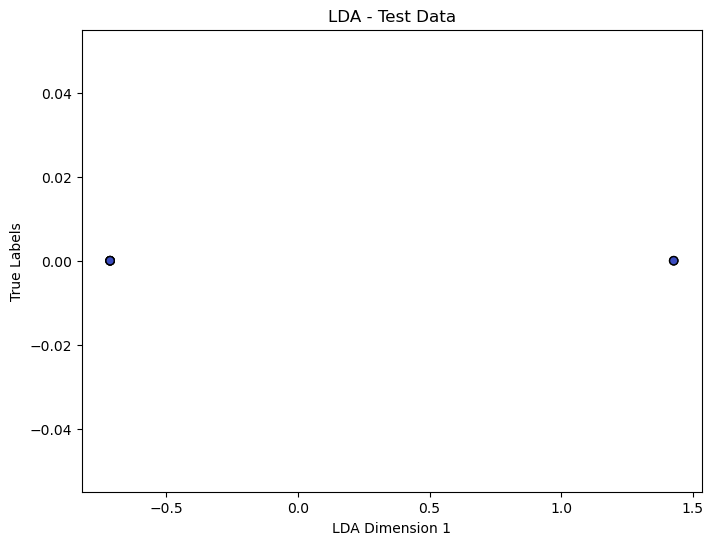

In [496]:
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_test_lda[:, 0], y_test, c=y_pred, cmap='coolwarm', marker='o', edgecolor='k')
plt.title('LDA - Test Data')
plt.xlabel('LDA Dimension 1')
plt.ylabel('True Labels')
plt.show()

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

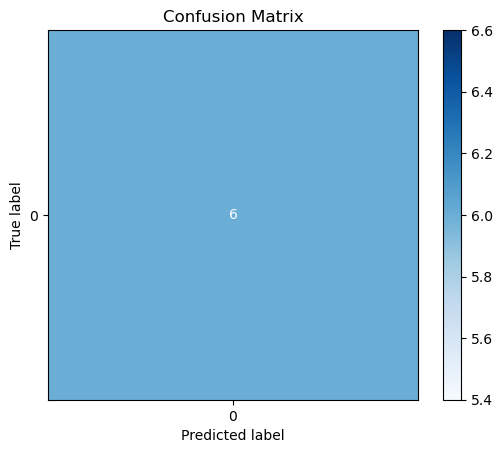

In [512]:
plot_confusion_matrix(y_test,y_pred)


- Confusion Matrix: Helps you understand the counts of correct and incorrect classifications.
- Accuracy: Overall correctness of the model.
- Precision: How many of the predicted positives are actually positive.
- Recall: How many of the actual positives are correctly predicted.
- F1 Score: Balances precision and recall.
- Specificity: How many of the actual negatives are correctly predicted.
Interpreting these metrics helps you understand your model’s performance in different aspects and identify areas for improvement

# Logistic Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Define features and target
X = df_filtered_night[['late','sentpositive','urls','is_named','cnn', 'adwords', 'weekend_int']]
y = df_filtered_night['label']

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

In [ ]:
# Calculate metrics
linear_accuracy = accuracy_score(y_test, y_pred)
linear_precision = precision_score(y_test, y_pred)
linear_recall = recall_score(y_test, y_pred)
linear_f1 = f1_score(y_test, y_pred)

In [ ]:
# Saving the results
linear_results = {
    'Model': 'Linear Regression',
    'Accuracy': linear_accuracy,  
    'Precision': linear_precision, 
    'Recall': linear_recall,  
    'F1 Score': linear_f1  
}
results.append(linear_results)

In [ ]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

In [ ]:
# Print the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [ ]:
# Initialize the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
tree_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = tree_model.predict(X_test)

In [ ]:
# Calculate the accuracy
dt_accuracy = accuracy_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred)
dt_recall = recall_score(y_test, y_pred)
dt_f1 = f1_score(y_test, y_pred)

In [ ]:
# Saving the results
dt_results = {
    'Model': 'Decision Tree',
    'Accuracy': dt_accuracy,  
    'Precision': dt_precision, 
    'Recall': dt_recall,  
    'F1 Score': dt_f1  
}
results.append(dt_results)

In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'], rounded=True, fontsize=12)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = rf_model.predict(X_test)

In [ ]:
# Calculate the metrics
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

In [ ]:
# Saving the results
rf_results = {
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy,  
    'Precision': rf_precision, 
    'Recall': rf_recall,  
    'F1 Score': rf_f1  
}
results.append(rf_results)

In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

# XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

In [ ]:
# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

In [ ]:
# Calculate the metrics
xg_accuracy = accuracy_score(y_test, y_pred)
xg_precision = precision_score(y_test, y_pred)
xg_recall = recall_score(y_test, y_pred)
xg_f1 = f1_score(y_test, y_pred)

In [ ]:
# Saving the results
xg_results = {
    'Model': 'XGBoost',
    'Accuracy': xg_accuracy,  
    'Precision': xg_precision, 
    'Recall': xg_recall,  
    'F1 Score': xg_f1  
}
results.append(xg_results)

In [ ]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Plot feature importances
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance')
plt.show()

# Summary table of all models

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print(results_df)